# Design of Lowpass FIR filters using the Window method

**Topics:**
* The window filer design method

**Learning goals:**
* Understanding how the IDTFT can be used to design FIR filters
* Understanding how window functions can improve stopband attenuation
* Experiencing how stopband attenuation, transition width and filter order are connected

**Libraries and notebook-config:**

In [1]:
from docutils.nodes import label
from numpy import sin, cos, pi, exp, empty, mean, abs, angle # Sentrale matematiske funksjoner
import numpy as np                          # Importer funksjonalitet fra numpy biblioteket med prefiks "np"
import scipy.signal as sig                  # Importerer signalbehandlingsmodulen til scipy
import matplotlib.pyplot as plt             # Importer pyplot modulen i matplotlib med prefiks "plt"
from toolz import frequencies

plt.rcParams["figure.figsize"] = [8.00, 4.5]
plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.xmargin"] = 0.0

%matplotlib inline

### Introduction 

In problem 1 we learned about the frequency response of FIR filters, how it is calculated, and how it can be interpreted. The key property of FIR filters in particular to keep in mind is once again that convolution in the time domain equals multiplication in the frequency domain:
$$ x[n]*h[n] \stackrel{\mathrm{DTFT}}{\longleftrightarrow} X\left(\hat{\omega}\right)\cdot H \left(\hat{\omega}\right) $$ 
In this problem we will have a closer look at how a particular frequency response $H(\hat{\omega})$, that of a lowpass filter, can be achieved. In a way, FIR filter design is the inverse of spectral signal analysis: the goal is to design a signal $h[n]$ whose frequency content comes as close as possible to a particular desired frequency response.


### Designing a lowpass filter

The ideal lowpass filter $H_I(\hat{\omega})$ with cutoff frequency $\hat{\omega}_c$ has a "brick wall" shape and can be expressed mathematically in equation $1$, for discrete frequencies in the range $\pi \leq \hat{\omega} \leq \pi$.
$$H_I(\hat{\omega}) = \begin{cases} 1, & |\hat{\omega}| <= \hat{\omega}_c \\ 0, & |\hat{\omega}| > \hat{\omega}_c \end{cases} \tag{1}$$

Finding the correct filter impulse response $h[n]$ is *almost* as simple as calculating the Inverse Discrete-Time Fourier Transform (IDTFT) of $H(\hat{\omega})$, with some adjustments necessary to make the filter realizable. In this problem we will walk through the process step-by-step, and investigate *why* the various adjustments are necessary.


### Step 1: finding the ideal impulse response

The IDFT of $H_I(\hat{\omega})$ in equation $1$ can be calculated analytically, and can be expressed as follows:

$$
\begin{align}
h_I[n] &= \frac{\sin(\omega_c \cdot n) }{\pi \cdot n} \\ \\
&= \frac{\omega_c}{\pi} \cdot \text{sinc}\left(\frac{\hat{\omega}_c}{\pi}n \right), \ \ \ \ \  \text{sinc}(x) = \frac{\sin(\pi x)}{\pi x}
\end{align} \tag{2}
$$

In other words, if the signal $h_I[n]$ decribed above is the impulse response of a filter, the said filter will have the desired frequency response. There are a few problems however, the first of which being that the impulse response needs to be finite-length, while the $h_I[n]$ has infinite length.

## a)

Use equation $2$ to calculate the impulse response of a causal $M=21$-tap FIR lowpass filter with edge frequency $\omega_c = \frac{\pi}{4}$ for samples $0\leq n < M$. Then, use python to calculate the *magnitude response* $|H(\hat{\omega})|$ of said filter, and plot both the impulse response and magnitude response in a figure.<br>PS: The function [`sinc`](https://numpy.org/doc/stable/reference/generated/numpy.sinc.html) is useful when calcuating the impulse response, as it "knows" how to evaluate $0/0$.

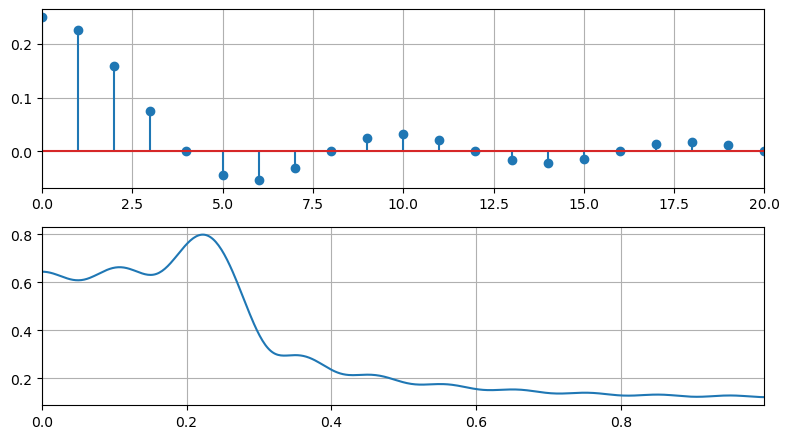

In [2]:
# WRITE YOUR CODE IN THIS CELL:
M = 21
n = np.arange(0,M) 
omega_c = pi/4

hn = omega_c/pi*np.sinc((omega_c/pi)*n)
Hm = np.fft.fft(hn, 1024)
frequencies = np.fft.fftfreq(1024, d=1) * 2 

plt.close("all")
fig, (ax1,ax2) = plt.subplots(2,1)
ax1.stem(n,hn)
ax2.plot(frequencies[:512],Hm[:512].__abs__())
plt.show()


[Here](figures/task2a_lf.png) is a suggestion of what the output of problem 1 may look like. As we can see, our filter has the general (ish) shape of a lowpass filter, but is otherwise very dissimilar to the ideal filter we want.

### Step 2: making adjustments for causal filters

The reason our filter performs so poorly is that we have not accounted for the delay a FIR filter typically imposes on the output $y[n]$. The frequency response $H_I(\hat{\omega})$ as defined in equation $1$ has a phase response $\angle H_I(\hat{\omega}) = 0$, something which is not possible to achieve with a causal filter.

To fix this, we need to add a certain delay to the impulse response $h_I[n]$. The best result is achieved when the impulse response is *symmetric* around a center point, which has the added bonus of ensuring a [linear phase response](https://en.wikipedia.org/wiki/Linear_phase) (all frequency components have the same delay).

## b)
Calculate the number of samples delay $D$ which need to be applied to $h_I[n]$ so that the $M=21$-tap FIR filter has a *symmetric* impulse response ($h[n] = h[M-1-n]$), and create a new delayed impulse response $h_D[n]$ as described below:

$$h_D[n] = \begin{cases} h_I[n-D], & 0 \leq n < M \\ 0, & \text{otherwise} \end{cases} $$

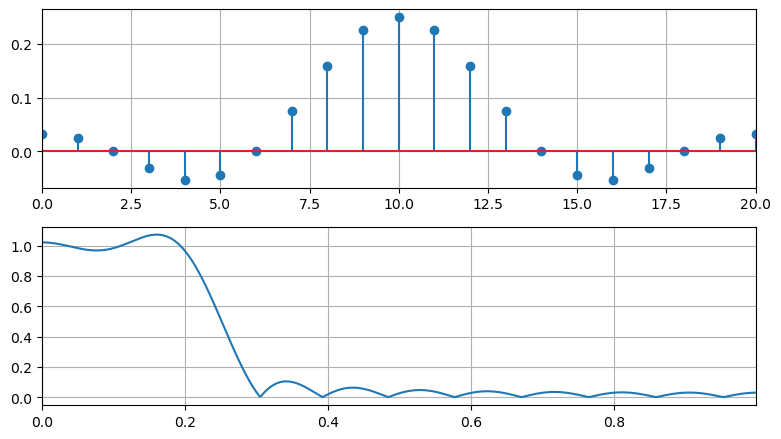

In [3]:
M = 21
D = M//2 #This is also the Counterpoint
n = np.arange(0,M) 
omega_c = pi/4
hn = omega_c/pi*np.sinc((omega_c/pi)*n)

#Here is one way to do it
h_D = np.zeros(M)
for element in n:
    h_D[element] = hn[(element-D)]

if ((M%2)!=0): 
    h_D[0:D] = np.flip(h_D[D+1:M]) #This is probably wrong but it works
else: 
    pass


"""
#Ask Kai about this
#Here is another way to do it
frequencies_1 = np.fft.fftfreq(M, d=1) * 2 * np.pi 

Hn = np.fft.fft(hn, M)
H_delay = Hn*np.exp(-1j * frequencies_1 * D)

h_D = np.fft.ifft(H_delay).real[:M]
"""

Padding = 1024
frequencies = np.fft.fftfreq(Padding, d=1) * 2       
Hd = np.fft.fft(h_D, Padding)        


plt.close("all")
fig, (ax1,ax2) = plt.subplots(2,1)
ax1.stem(n,h_D)
ax2.plot(frequencies[:(Padding//2)],Hd[:(Padding//2)].__abs__())
plt.show()

# WRITE YOUR CODE IN THIS CELL:

In [4]:
from hashlib import sha1
assert sha1(str(round(D)).encode('utf-8')+b'269e7').hexdigest() == '3ee10e6b93e8b0115aeba7eb42690eba16ba1265', 'Wrong answer for D :('
print('Correct answer for D :)')
assert np.allclose(h_D, h_D[::-1]), "Impulse response 'h_D' is not symmetric :("
print("Impulse response 'h_D' is symmetric =)")

Correct answer for D :)
Impulse response 'h_D' is symmetric =)


[Here](figures/task2b_lf.png) is a figure indicating what the impulse response should look like.

## c) 

Use python to produce a plot of the Magnitude and Phase response of $h_D[n]$. The magnitude plot should be logarithmic scale in decibels (dB). Analyze the figure to determine the *stopband attenuation* `stop_att` of the filter.

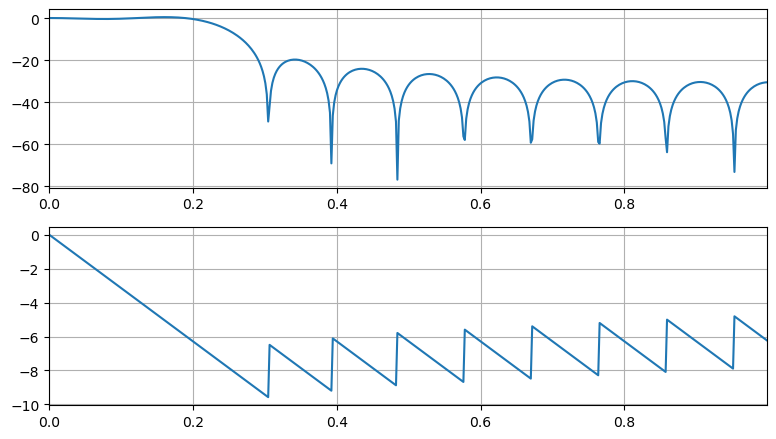

In [5]:
M = 21

D = M//2 #This is also the Counterpoint

n = np.arange(0,M) 
omega_c = pi/4
hn = omega_c/pi*np.sinc((omega_c/pi)*n)

h_D = np.zeros(M)

for element in n:
    h_D[element] = hn[(element-D)]
    
if ((M%2)!=0): 
    h_D[0:D] = np.flip(h_D[D+1:M]) #This is probably wrong but it works
else: 
    pass
        
Hd = np.fft.fft(h_D, 1024)        
frequencies = np.fft.fftfreq(1024) * 2 
        
plt.close("all")
fig, (ax1,ax2) = plt.subplots(2,1)
ax1.plot(frequencies[:512],20*np.log10(np.abs(Hd[:512])))
ax2.plot(frequencies[:512],np.unwrap(np.angle(Hd[:512]), period=2*pi))
plt.show()
# WRITE YOUR CODE IN THIS CELL:

#Why isn't this -20dB
stop_att = 20 

In [6]:
from hashlib import sha1
assert sha1(str(round(stop_att+0.5)).encode('utf-8')+b'38b4').hexdigest() == 'bb707f46b016f5cbf406bd7f81c216862321ab74', 'Wrong answer for stop_att :('
print('Correct answer for stop_att :)')

Correct answer for stop_att :)


### Step 3: determining the window function

As the name suggests, the "Window Design Method" involves using window functions. The filter in problem **c)** uses a *rectangular window* to truncate the impulse response $h_I[n]$, and can be described as

$$h_D[n] = h_I[n-D] \cdot w[n]$$

where $w[n] = u[n] - u[M]$. Just as in signal analysis, applying a window function to a signal causes spectral leakage, with frequency components "leaking" into the filter's stopband. By using a different window function $w[n]$ with better side lobe attenuation, we can improve the filter's stopband attenuation.

## d)

Add two new windowed filters to the frequency response plot from **c)** (you can choose which ones you want to try out), and use labels to differentiate the various window functions. How do different window functions impact filter properties, and what is the apparent tradeoff when increasing stopband attenuation?

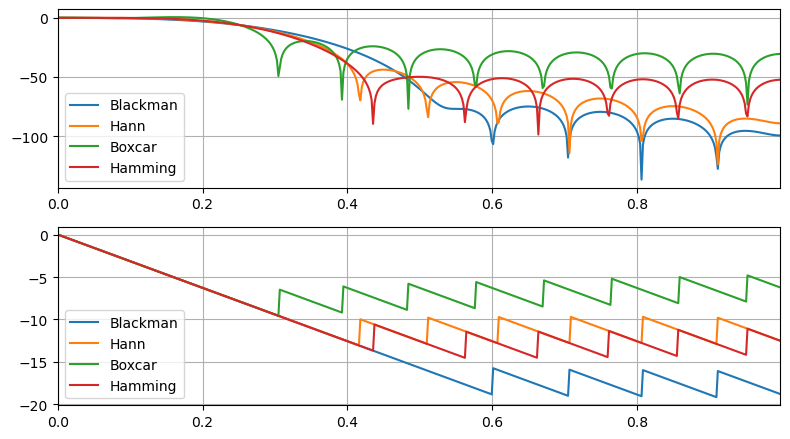

In [7]:
# WRITE YOUR CODE IN THIS CELL:
h_D1 = h_D.copy() * sig.windows.blackman(M)
h_D2 = h_D.copy() * sig.windows.hann(M)
h_D3 = h_D.copy() * sig.windows.boxcar(M)
h_D4 = h_D.copy() * sig.windows.hamming(M)

Hd1 = np.fft.fft(h_D1, 1024)   
Hd2 = np.fft.fft(h_D2, 1024)  
Hd3 = np.fft.fft(h_D3, 1024)
Hd4 = np.fft.fft(h_D4, 1024)
frequencies = np.fft.fftfreq(1024) * 2 
        
plt.close("all")
fig, (ax1,ax2) = plt.subplots(2,1)
ax1.plot(frequencies[:512],20*np.log10(np.abs(Hd1[:512])),label="Blackman")
ax1.plot(frequencies[:512],20*np.log10(np.abs(Hd2[:512])), label="Hann")
ax1.plot(frequencies[:512],20*np.log10(np.abs(Hd3[:512])), label="Boxcar")
ax1.plot(frequencies[:512],20*np.log10(np.abs(Hd4[:512])), label="Hamming")
ax2.plot(frequencies[:512],np.unwrap(np.angle(Hd1[:512]), period=2*pi), label="Blackman")
ax2.plot(frequencies[:512],np.unwrap(np.angle(Hd2[:512]), period=2*pi), label="Hann")
ax2.plot(frequencies[:512],np.unwrap(np.angle(Hd3[:512]), period=2*pi), label="Boxcar")
ax2.plot(frequencies[:512],np.unwrap(np.angle(Hd4[:512]), period=2*pi), label="Hamming")
ax1.legend(loc="best")
ax2.legend(loc="best")
plt.show()

[Here](figures/task2d_lf.png) you can see what the frequency response will look like for e.g. rectangular, hamming and blackman windows.

ANSWER THEORY QUESTIONS HERE: The trade of by increasing the stopband attenuation is that the lowpass filters dampens the high frequency harder, but slower.

### Step 4: determining number of filter taps $M$

One important filter parameter to consider when designing a filter is the *transition width*, i.e. how wide is the frequency band between the point where the passband stops $\hat{\omega}_{pass}$ and the point where the stopband begins $\hat{\omega}_{stop}$. One filter parameter which directly impacts transition width is the number of filter taps $M$, with the transition width being inversely proportional to number of filter taps. For any given window function there is a formula for minimum number of taps required as a function of transition width (TW), although we will not go into much further detail here and use a more "brute force" approach instead.

## e)

Assume the following:
- A **hamming** window is used in designing a lowpass filter with $-6dB$ cutoff frequency $\omega_c = \frac{\pi}{4}$
- We define $50\text{dB}$ attenuation as the criteria for the filter's stopband
     - In other words, the stopband starts precisely where $|H(\hat{\omega})| < -50\text{dB}$

Use either trial and error, or an automated iterative approach to determine the smallest number of filter taps `M_min` required to achieve a transition width $\text{TW} \leq \frac{\pi}{10}$. Create a figure showing the frequency response of the final filter. <br>PS: the cutoff frequency $\omega_c$ is located in the middle of the transition band.

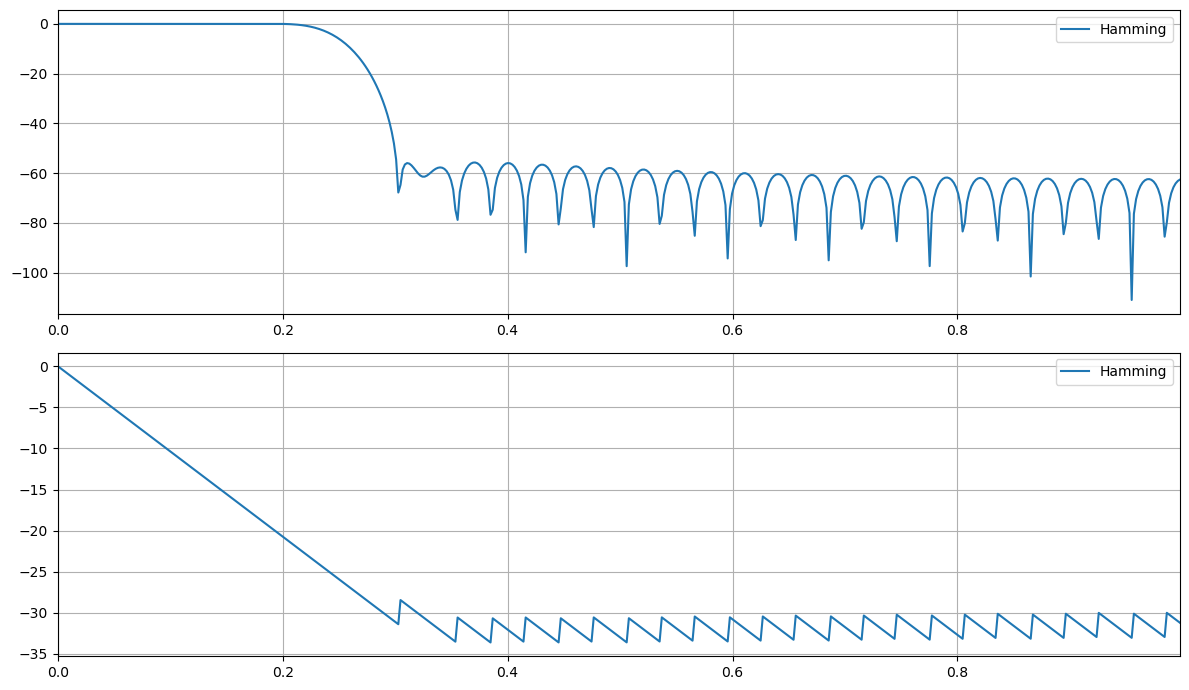

In [37]:
## I need some Propper explenation
M = M_min = 67

D = M//2 #This is also the Counterpoint
    
n = np.arange(0,M) 
omega_c = pi/4
hn = omega_c/pi*np.sinc((omega_c/pi)*n)
    
h_D = np.zeros(M)
    
for element in n:
    h_D[element] = hn[(element-D)]
        
h_D[0:D] = np.flip(h_D[D+1:M]) #This is probably wrong but it works
           
Hd = np.fft.fft(h_D, 1024)        
frequencies = np.fft.fftfreq(1024) * 2 
    
h_D4 = h_D.copy() * sig.windows.hamming(M)
Hd4 = np.fft.fft(h_D4, 1024)
    
Hd4_mag = 20*np.log10(np.abs(Hd4[:512]))
    
        
plt.close("all")
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(12,7))
ax1.plot(frequencies[:512],Hd4_mag, label="Hamming")
ax2.plot(frequencies[:512],np.unwrap(np.angle(Hd4[:512]), period=2*pi), label="Hamming")
ax1.legend(loc="best")
ax2.legend(loc="best")
plt.show()

# WRITE YOUR CODE IN THIS CELL:

[Here](figures/task2e_lf.png) you can see what the final frequency response should look like.

In [38]:
from hashlib import sha1
assert sha1(str(round(M_min+0.5)).encode('utf-8')+b'2b2b9').hexdigest() == '8d67049db49694faddf3a4297ef24b0eafc4132c', 'Wrong answer for M_min :('
print('Correct answer for M_min :)')

Correct answer for M_min :)


### Quick note on design algorithms
In this taks we have decided to explore the window design method, as it is a good way to gain insight into the main principles of designing FIR filters. It is not the most optimal filter design method in terms of "best properties per filter tap" however, that distinction would likely go to the [remez exchange algorithm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.remez.html) which uses an iterative approach to "tuning" each filter coefficient. 